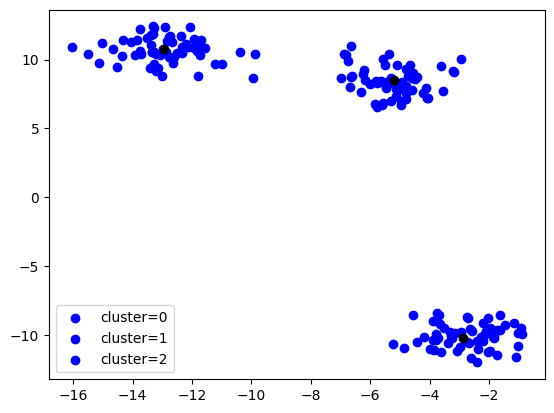

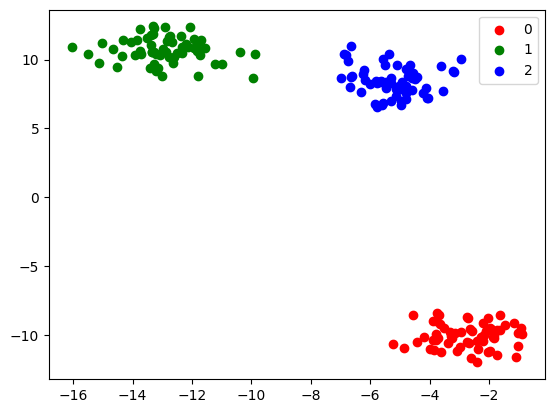

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def assign(data, centers):
    # data - nr_features x samples
    # centers - nr_features x nr_clust

    nr_clust = len(centers[0])
    nr_samples = len(data[1])

    diffs = np.empty((nr_clust, nr_samples))
    
    for i in range(nr_clust):
        difference = data - centers[:, i][:, None]
        diffs[i] = np.sum(np.square(difference), axis=0)
    
    assigned_clusters = np.argmin(diffs, axis=0)
    
    return assigned_clusters
        

def clust(data, nr_clust, n_init=10, max_iter=300):
    min_cost = float('inf')
    assert nr_clust <= data.shape[1]

    # ubaciti tol
    for id_init in range(n_init):

        rng = np.random.default_rng()
        rand_choice = rng.choice(data.shape[1], size=(nr_clust, ), replace=False) # this is used instead of np.random.uniform so we dont have 2 clusters on 1 point

        # rand_choice =  np.random.randint(low=0, high=data.shape[1], size=(nr_clust, ))
        clust_pos = data[:,rand_choice]

        for i in range(max_iter):

            # print(f'{len(clust_pos)=}')
             
            assigned = assign(data, clust_pos)

            for cur_clust in range(nr_clust):
                belonging = data[:, assigned == cur_clust]
                # if len(belonging > 0):
                mean = np.mean(belonging, axis=1)
                clust_pos[:, cur_clust] = mean


        cost = 0
        for i in range(nr_clust):
            sq = np.square(data[:, assigned == i] - clust_pos[:, i, None])
            cost += np.sum(sq)

        if cost < min_cost:
            min_cost = cost
            ret = clust_pos, assigned
    
    return ret

def generate_test_kmeans_data():

    nr_clust = 3
    x_clust = np.random.randn(nr_clust, 1)*5
    y_clust = np.random.randn(nr_clust, 1)*10

    nr_observations_per_clust = 60
    x_seperate = [np.random.randn(nr_observations_per_clust)+x_clust[i] for i in range(nr_clust)]
    y_seperate = [np.random.randn(nr_observations_per_clust)+y_clust[i] for i in range(nr_clust)]

    x = np.reshape(x_seperate, (nr_clust*nr_observations_per_clust))
    y = np.reshape(y_seperate, (nr_clust*nr_observations_per_clust))

    data = np.empty((2, nr_clust*nr_observations_per_clust))
    data[0,] = x
    data[1,] = y
    
    # "data" is all the kmeans algorithm needs to work

    return data, x_clust, y_clust, x_seperate, y_seperate

# ----

data, x_clust, y_clust, x_seperate, y_seperate = generate_test_kmeans_data()

nr_clust = 3

for i in range(nr_clust):
    plt.scatter(x_seperate[i], y_seperate[i], label='cluster='+str(i), color='blue')
    plt.scatter(x_clust[i], y_clust[i], color='black')
    plt.legend()

plt.show()

# ---

clust_pos, assigned = clust(data, 3)
colors = ['red', 'green', 'blue']

for i in range(nr_clust):
    cur = data[:, assigned == i]
    plt.scatter(cur[0, ], cur[1, ], color=colors[i], label=str(i))

plt.legend()
plt.show()

In [2]:
#!pip install opencv-python

import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread("lenna.png")
img[:, :, [0, 2]] = img[:, :, [2, 0]]  # switch because imread does not read RGB in order
print(type(img))
print(img.shape)
img = np.array(img, dtype='float')

img /= 255

print(np.max(img))

<class 'numpy.ndarray'>
(512, 512, 3)
1.0


k= 10
new shape:  (52, 52, 3)
(2704, 3)


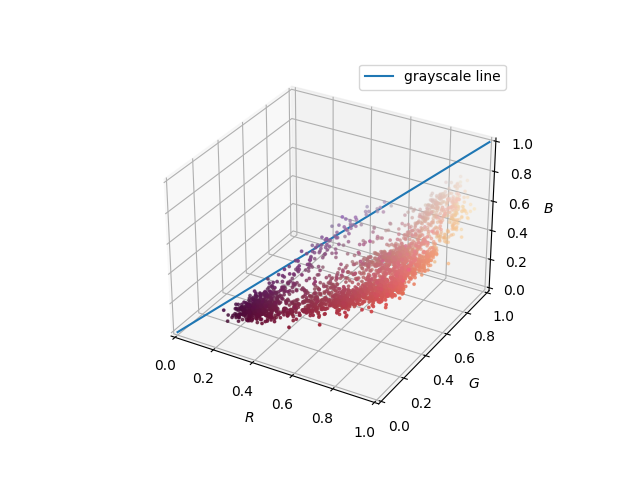

In [3]:
import numpy as np
%matplotlib widget

# k = int(np.sqrt(im.shape[0]*im.shape[1]/200))
k = 10
print('k=', k)
print('new shape: ', img[::k, ::k].shape)
small_arr = img[::k, ::k, :].reshape((-1, 3))
print(small_arr.shape)
# plt.hist(small[:,0], bins=20)
# plt.show()

ax = plt.gcf().add_subplot(projection='3d')
ax.scatter(small_arr[:, 0], small_arr[:, 1], small_arr[:, 2], c=small_arr, s=3)
ax.set_xlabel(r'$R$')
ax.set_ylabel(r'$G$')
ax.set_zlabel(r'$B$')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

x = np.linspace(0, 1, 10)
ax.plot(x, x, x, label='grayscale line')
ax.legend()

In [4]:
clust_pos, assigned = clust(small_arr.T, 8)

(3, 8)


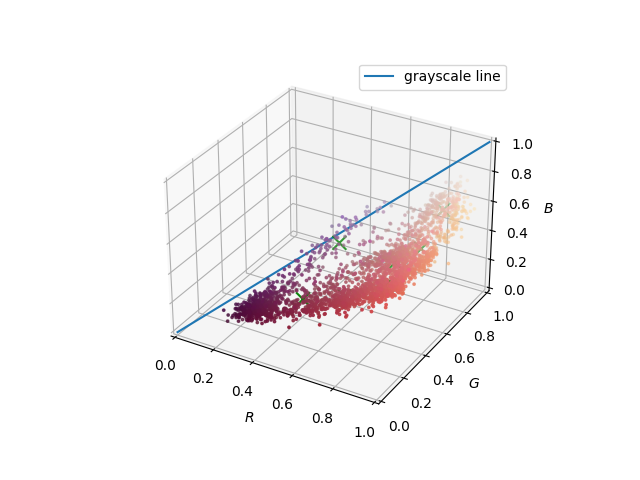

In [5]:
print(clust_pos.shape)

ax.scatter(clust_pos[0], clust_pos[1], clust_pos[2], s=100, color='green', marker='x')
# plt.gcf().show()
plt.show()

In [6]:
from PIL import Image

# print(assigned)
compressed = clust_pos.T[assigned]

compressed = np.reshape(compressed, img[::k, ::k].shape)
print(compressed.shape)

# print(compressed.shape)
# Image.fromarray(np.array(compressed*255, dtype='int'))
scaled = compressed*255
scaled = np.minimum(scaled, 255*np.ones(scaled.shape))
comp_int = np.array(scaled, dtype=np.uint8)

PIL_image = Image.fromarray(comp_int)
PIL_image.show()

(52, 52, 3)


In [7]:
img_arr = np.reshape(img, (-1, 3)).T
print(img.shape, img_arr.shape)

assigned = assign(img_arr, clust_pos)
compressed = clust_pos.T[assigned]

compressed = np.reshape(compressed, img.shape)

comp_int = np.array(compressed*255, dtype=np.uint8)
PIL_image = Image.fromarray(comp_int)
PIL_image.show()

(512, 512, 3) (3, 262144)


In [8]:
def compress_img(img, nr_clust, nr_points=256):
    # this function summarises all the code so far
    # nr_points - the image will be compressed so that it has approximately nr_points so the kmeans algorithm will run faster

    k = int(np.sqrt(img.shape[0]*img.shape[1]/nr_points))
    print('k=', k)
    small_arr = img[::k, ::k, :].reshape((-1, 3))

    clust_pos, assigned = clust(small_arr.T, nr_clust)

    img_arr = np.reshape(img, (-1, 3)).T

    assigned = assign(img_arr, clust_pos)
    compressed = clust_pos.T[assigned]

    compressed = np.reshape(compressed, img.shape)
    scaled = np.clip(compressed*255, 0, 255)
    # comp_int = np.array(scaled, dtype=np.uint8)
    
    comp_int = scaled.astype(np.uint8)

    for i in scaled:
        for j in i:
            for k in j:
                if k > 255 or k < 0:
                    print(k)


    # scaled = compressed*255
    # scaled = np.minimum(scaled, 255*np.ones(scaled.shape))
    # comp_int = np.array(scaled, dtype=np.uint8)

    return Image.fromarray(comp_int)



img = cv2.imread("lenna.png")
img[:, :, [0, 2]] = img[:, :, [2, 0]]  # switch because imread does not read RGB in order
img = np.array(img, dtype='float')
img /= 255

compress_img(img, 4).show()

k= 32


In [9]:
# for nr_clust in [1, 2, 4, 8, 16, 32]:
#     PIL_image = compress_img(img, nr_clust)
#     PIL_image.show(title='nr_clusters='+str(nr_clust))

k= 32
k= 32
k= 32
k= 32
k= 32
k= 32


In [12]:
a = compress_img(img, 256, 512)
a.save('a.png')
# compress_img(img, 128, 1000).show()

k= 22


c:\Users\milos\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\milos\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
